In [8]:
# Libraries + setup
import pandas as pd
import sqlite3
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt

In [ ]:
# Load customer table
conn = sqlite3.connect("../data/project.db")

query = """
WITH last_date AS (
    SELECT MAX(InvoiceDate) AS max_date
    FROM transactions
),
customer_agg AS (
    SELECT
        "Customer ID" AS customer_id,
        COUNT(DISTINCT Invoice) AS frequency,
        SUM(Quantity * Price) AS monetary,
        MAX(InvoiceDate) AS last_purchase_date
    FROM transactions
    GROUP BY "Customer ID"
)
SELECT
    c.customer_id,
    c.frequency,
    c.monetary,
    CAST(julianday(l.max_date) - julianday(c.last_purchase_date) AS INT) AS recency_days,
    CASE
        WHEN julianday(l.max_date) - julianday(c.last_purchase_date) > 90 THEN 1
        ELSE 0
    END AS churned
FROM customer_agg c
CROSS JOIN last_date l;
"""

df = pd.read_sql_query(query, conn)
df.head()


,customer_id,frequency,monetary,recency_days,churned
0,12346,11,372.86,164,1
1,12347,2,1323.32,2,0
2,12348,1,222.16,73,0
3,12349,3,2671.14,42,0
4,12351,1,300.93,10,0


In [ ]:
x = df[["frequency", "monetary", "recency_days"]]
y = df["churned"]

# Stratification handles class imbalance
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.2, random_state = 42, stratify = y
)

# Scale features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Train baseline logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(x_train_scaled, y_train)

# Model evaluation
y_pred = model.predict(x_test_scaled)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       576
           1       1.00      0.98      0.99       287

    accuracy                           0.99       863
   macro avg       0.99      0.99      0.99       863
weighted avg       0.99      0.99      0.99       863

[[576   0]
 [  7 280]]


Because churn is defined directly using recency, the baseline model performs extremely well. This confirms that recency is the dominant signal, and motivates exploring models that rely more heavily on behavioural features such as frequency and monetary value. Can we detect churn before inactivity becomes extreme?

In [5]:
x_no_recency = df[["frequency", "monetary"]]

x_train, x_test, y_train, y_test = train_test_split(
    x_no_recency, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

model_nr = LogisticRegression(max_iter=1000)
model_nr.fit(x_train_scaled, y_train)

y_pred_nr = model_nr.predict(x_test_scaled)

print(classification_report(y_test, y_pred_nr))
print(confusion_matrix(y_test, y_pred_nr))


              precision    recall  f1-score   support

           0       0.77      0.81      0.79       576
           1       0.57      0.51      0.54       287

    accuracy                           0.71       863
   macro avg       0.67      0.66      0.66       863
weighted avg       0.70      0.71      0.70       863

[[467 109]
 [142 145]]


The baseline model including recency achieved near-perfect performance, which was expected because churn was defined using inactivity. When recency was removed, performance dropped significantly, highlighting the challenge of predicting churn before inactivity becomes extreme. This second model better reflects a real-world early-warning system.

467 correctly classified non-churners and 109 falsely flagged as churners. 145 correctly identified churners and 142 missed churners. For non-churners (class 0), a precision of 0.77 means that the model correctly identifies non-churners 77% of the time and a recall of 0.81 means that it catches 81% of real non-churners. For churners (class 1), a precision of 0.57 and a recall of 0.51 means that the model identifies churners 57% of the time and catches 51% of actual churners.
i.e. We can identify about half of customers who will churn, and slightly more than half of the customers we flag are truly at risk.




=== Default threshold = 0.5 ===
[[467 109]
 [142 145]]
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       576
           1       0.57      0.51      0.54       287

    accuracy                           0.71       863
   macro avg       0.67      0.66      0.66       863
weighted avg       0.70      0.71      0.70       863


=== Threshold comparison (churn = class 1) ===


c:\Users\gloob\anaconda3\envs\py312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gloob\anaconda3\envs\py312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gloob\anaconda3\envs\py312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,threshold,accuracy,precision_churn,recall_churn,f1_churn,tn,fp,fn,tp
0,0.2,0.555041,0.421394,0.905923,0.575221,219,357,27,260
1,0.3,0.608343,0.452336,0.843206,0.588808,283,293,45,242
2,0.4,0.657010,0.489412,0.724739,0.584270,359,217,79,208
3,0.5,0.709154,0.570866,0.505226,0.536044,467,109,142,145
4,0.6,0.667439,0.000000,0.000000,0.000000,576,0,287,0


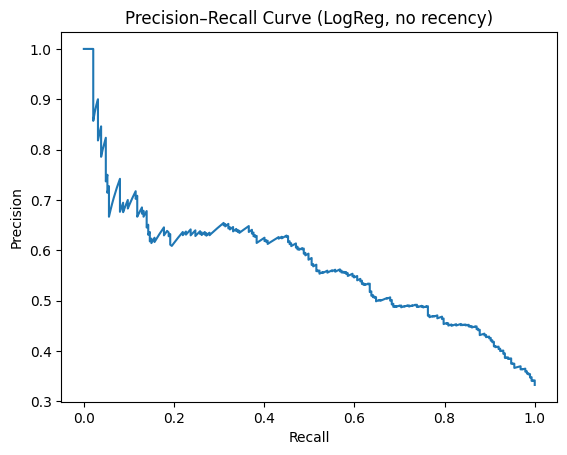


Suggested threshold for recall >= 0.65: 0.416

=== Final evaluation at threshold = 0.416 ===
[[389 187]
 [100 187]]
              precision    recall  f1-score   support

           0       0.80      0.68      0.73       576
           1       0.50      0.65      0.57       287

    accuracy                           0.67       863
   macro avg       0.65      0.66      0.65       863
weighted avg       0.70      0.67      0.68       863



In [11]:
# Using multiple decision thresholds
# Define features and target (NO recency)
x = df[["frequency", "monetary"]]
y = df["churned"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Scale + train logistic regression
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(x_train_scaled, y_train)

# Predicted probabilities for churn = 1
y_prob = model.predict_proba(x_test_scaled)[:, 1]

# Baseline (default threshold 0.5)
y_pred_default = (y_prob >= 0.5).astype(int)
print("\n=== Default threshold = 0.5 ===")
print(confusion_matrix(y_test, y_pred_default))
print(classification_report(y_test, y_pred_default))

# Evaluate multiple thresholds
def evaluate_threshold(threshold: float):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    churn_precision = report["1"]["precision"]
    churn_recall = report["1"]["recall"]
    churn_f1 = report["1"]["f1-score"]
    accuracy = report["accuracy"]
    return {
        "threshold": threshold,
        "accuracy": accuracy,
        "precision_churn": churn_precision,
        "recall_churn": churn_recall,
        "f1_churn": churn_f1,
        "tn": cm[0, 0],
        "fp": cm[0, 1],
        "fn": cm[1, 0],
        "tp": cm[1, 1],
    }

thresholds_to_try = [0.2, 0.3, 0.4, 0.5, 0.6]

results = pd.DataFrame([evaluate_threshold(t) for t in thresholds_to_try])
print("\n=== Threshold comparison (churn = class 1) ===")
display(results.sort_values("threshold"))

# Precision–Recall curve (visual trade-off)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (LogReg, no recency)")
plt.show()

# Choose a threshold based on a target recall (optional helper)
# Example: choose the lowest threshold that achieves at least 0.65 recall
target_recall = 0.65

# Note: precision_recall_curve returns arrays aligned such that thresholds has len-1
# recall/precision have length len(thresholds)+1
# We'll find candidate thresholds based on recall for each threshold point.
candidate_idxs = np.where(recall[:-1] >= target_recall)[0]

if len(candidate_idxs) > 0:
    chosen_idx = candidate_idxs[-1]  # highest threshold while meeting recall target
    chosen_threshold = pr_thresholds[chosen_idx]
    print(f"\nSuggested threshold for recall >= {target_recall:.2f}: {chosen_threshold:.3f}")
else:
    chosen_threshold = 0.5
    print(f"\nNo threshold reached recall >= {target_recall:.2f}. Using default 0.5")

# Final evaluation at chosen threshold
y_pred_chosen = (y_prob >= chosen_threshold).astype(int)

print(f"\n=== Final evaluation at threshold = {chosen_threshold:.3f} ===")
print(confusion_matrix(y_test, y_pred_chosen))
print(classification_report(y_test, y_pred_chosen))
